# Covid-19 Vignette
### ISE 535 Final Project by Jeremias A. Endrina Jr.

In [54]:
import os
os.getcwd()

'/Users/jeremiasendrinajr/Documents/GitHub/535Project'

## Table of Contents

1. [Introduction](#1.-Introduction)
2. [Python Packages](#2.-Python-Packages)
3. [Functions](#3.-Functions)
4. [Data Generation and Wrangling](#4.-Data-Generation-and-Wrangling)
5. [Visualizations with Widgets and Tables](#5.-Visualizations-with-Widgets-and-Tables)
6. [Forecasting](#6.-Forecasting)

## 1. Introduction

As a Statistics teacher, I often require my students to come-up with a final project applying what they learned in class. My school offers AP Computer Science where some of my students are taking or have taken such class. It would be interesting to collaborate with the teacher of this computer science course and integrate both our courses by requiring our students to come-up with a final project with coding using Python and Statistics in it. Thus, this project will be a good example for our students to follow.

This project will use data from [Covid-19 API](https://covid19api.com/). All data are queried as json files which are then converted into dataframes with the help of different functions. Next, exploratory data analysis will be conducted through tables and visualitions to check for patterns, similarities and differences. After which, future predictions or forecasting using machine learning will be employed. Due to computational limitations, we will limit our analysis to South East Asian countries. Although this can easily be extended to more countries if the user desired to do so.

The best feature of this project is that the results are always recent. Since the data used in this project is dependent on the API, once the API is updated and we run the codes in this project then we can be assured that the results are up to date. 

## 2. Python Packages

Below are the packages that we will use in this vignette.

In [55]:
import numpy as np                   #to work with arrays    
import pandas as pd                  #to work with dataframes
import requests                      #to query with covid-1 API
import plotly.express as px          #to produce pretty plots
import plotly.graph_objs as go       #to produce pretty plots
import datetime                      #to work with time values
from datetime import datetime        #to work with time values
import warnings                      #to hide unnecessary warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

from ipywidgets import interact, IntSlider, interactive, widgets, interact_manual, fixed
from pandas import DataFrame
from fbprophet import Prophet

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

pd.options.display.float_format = "{:.2f}".format
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

from IPython.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 3. Functions


### 3.1. List of Countries with Covid-19 Data
The API is dependent on the reports submitted by participating countries. We will create `countries()` function that will return a list of countries that have Covid-19 data available. Note: After careful explorations, some countries in the list have incomplete data. 

In [56]:
def countries():
    url = "https://api.covid19api.com/countries"                          #url to be queried
    payload = {}                                                          #a function required by Covid-19 API
    headers = {'X-Access-Token':'a3c98472-2928-4752-9d71-083ce072213c'}   #subscription code ($10 monthly for access.)
    response = requests.request("GET", url, headers=headers, data=payload)#query request 
    data = response.json()                                                #convert query to json format
    df = DataFrame(data).sort_values(by='Country')                        #convert json file to dataframe
    return df

### 3.2. Generate All Data of a Country
This `countryData()` function will query all data of the country being specified since the start of the pandemic. We can refer to the list of countries that will be generated by `countries()` function for the country argument to pass.

In [57]:
def countryData(country):
    url1 = "https://api.covid19api.com/dayone/country/"                   #base url to be queried
    country = country
    url = url1+country                                                    #complete url to be queried
    payload={}
    headers = {'X-Access-Token': 'a3c98472-2928-4752-9d71-083ce072213c'}
    response = requests.request("GET", url, headers=headers, data=payload)
    data = response.json()
    df = DataFrame(data)
    return df

### 3.3. Generate Latest Data of a Country
This `latestCountry()` function will generate the latest reported data of the country specified. If the API is updated and we run this function, then we will get the most current data of that country.

In [58]:
def latestCountry(country):
    url1 = "https://api.covid19api.com/dayone/country/"
    country = country
    url = url1+country
    payload={}
    headers = {'X-Access-Token': 'a3c98472-2928-4752-9d71-083ce072213c'}
    response = requests.request("GET", url, headers=headers, data=payload)
    data = response.json()
    df = DataFrame(data)
    return df.tail(1)                                                      #return the most current data

## 4. Data Generation and Wrangling
Now that we have functions to help us query data from the Covid-19 API, then we are ready to generate the data that we want and do some data wrangling such as creating new variables, converting date column to something useful in data series analysis and etc.

### 4.1. List of Countries with Covid-19 Data from the API
If we run the `countries()` function, this will return a dataframe of countries that have Covid-19 data. Note though that not all countries have continued to report data until today.

In [59]:
dfCountries = countries()                                                 #no argument is needed in this function
dfCountries

,Country,Slug,ISO2
215,ALA Aland Islands,ala-aland-islands,AX
109,Afghanistan,afghanistan,AF
40,Albania,albania,AL
23,Algeria,algeria,DZ
13,American Samoa,american-samoa,AS
121,Andorra,andorra,AD
171,Angola,angola,AO
195,Anguilla,anguilla,AI
234,Antarctica,antarctica,AQ
193,Antigua and Barbuda,antigua-and-barbuda,AG


### 4.2. Latest Cases for South East Asian Countries
As part of the limitations of this project, we will only focus on comparing cases of the South East Asian nations. Although it can be noted that the codes in this project can easily be edited to include other countries.

In [60]:
seCountries = ["brunei","myanmar","cambodia","timor-leste","indonesia",   #create a list of South East Asian nations
               "malaysia", "philippines","singapore","thailand","vietnam"]
dataSE = []

for country in seCountries:                                               #loop through each country in the list
    df = latestCountry(country)                                           #generate latest data of the country
    columns = list(df)                                                    #retrieve column names
    values = df.iloc[0]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)                                          
    dataSE.append(a_dictionary)                                           #append data to create a dataframe

dataSE = DataFrame(dataSE).sort_values('Country')                         #sort countries alphabetically
dataSE['Lat'] = pd.to_numeric(dataSE['Lat'])                              #convert Lat column to numeric
dataSE['Lon'] = pd.to_numeric(dataSE['Lon'])                              #convert Lon column to numeric
dataSE['Date'] = pd.to_datetime(dataSE.Date, format='%Y-%m-%d %H:%M:%S')  #convert date to time format
dataSE['Date'] = dataSE['Date'].dt.strftime('%Y-%m-%d')

dataSE                                                                    #print dataframe

,ID,Country,CountryCode,Province,City,CityCode,Lat,Lon,Confirmed,Deaths,Recovered,Active,Date
0,de16b69e-55bb-47f6-a53d-d165006aeec0,Brunei Darussalam,BN,,,,4.54,114.73,14701,96,0,14605,2021-11-24
2,5b531158-8f0a-454b-b8bd-0173daab6ea6,Cambodia,KH,,,,12.57,104.99,119943,2909,0,117034,2021-11-24
4,a48a2264-478d-4e39-99e4-4bd5ea720fb8,Indonesia,ID,,,,-0.79,113.92,4253992,143753,0,4110239,2021-11-24
5,a9a214c0-9f2f-4e85-9163-4d531a4ae12f,Malaysia,MY,,,,4.21,101.98,2597080,30110,0,2566970,2021-11-23
1,a0a36188-53e4-426c-bc4a-42705f1ead58,Myanmar,MM,,,,21.91,95.96,519102,19041,0,500061,2021-11-24
6,b3f107e0-33e5-4b82-8f82-23af18c2135e,Philippines,PH,,,,12.88,121.77,2827820,47482,0,2780338,2021-11-24
7,7049d43f-d81f-4b2c-a243-6543664f06da,Singapore,SG,,,,1.35,103.82,255431,672,0,254759,2021-11-24
8,a13c6bc2-2e32-4946-8e4a-beb753c4d54f,Thailand,TH,,,,15.87,100.99,2076135,20489,0,2055646,2021-11-24
3,7c570398-1811-49e3-9160-b99d34dc2e92,Timor-Leste,TL,,,,-8.87,125.73,19820,122,0,19698,2021-11-24
9,8fce737c-1d62-4ff2-8ec9-27fce931db6c,Viet Nam,VN,,,,14.06,108.28,1143967,24118,0,1119849,2021-11-24


###  4.3. All Data for All South East Asian Countries
Previously, we only generated the latest data of all South East Asian Countries. In this part of the project, we will generated and put into 1 big data set all data since the start of the pandemic. Again, we are limiting our project to South East Asian nations which can be easily extended to other countries.

In [61]:
bigData = []
for country in seCountries:
    df = countryData(country)
    bigData.append(df)
bigData = pd.concat(bigData)

#cleaning and filtering for widgets use
bigData = bigData[['Country', 'CountryCode','Confirmed','Deaths','Recovered','Active','Date']]
bigData['Date'] = pd.to_datetime(bigData.Date, format='%Y-%m-%d %H:%M:%S')
bigData['Date'] = bigData['Date'].dt.strftime('%Y-%m-%d')
bigData['Date']= pd.to_datetime(bigData["Date"])
bigData = bigData.reset_index(drop=True)

## 5. Visualizations with Widgets and Tables

### 5.1. Widgets
In this project, we will use widgets to build an interactive graphical user interface. Specifically, we will include text, radiobuttons, dropdowns and data picker. For more information about available widgets, visit [widgets list](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html).

In [62]:
layout = widgets.Layout(width='300px', height='30px')                    #specify lay-out of widgets

#text widget
countryFC = widgets.Text(
    value='Philippines',                                                 #specify initial value of widget
    placeholder='Philippines',
    description='Type-in Country:',                                      #description of what user needs to do
    layout=layout,
    disabled=False,
    style= {'description_width': 'initial'}
)

#radio button widget
varFC = widgets.RadioButtons(
    options=['Confirmed', 'Deaths', 'DailyCases', 'DailyDeaths'],        #provide different options
    value='DailyCases',                                                  #specify initial value
    description='Click Variable:',                                       #description of what user needs to do
    disabled=False,
    style= {'description_width': 'initial'}
)

#dropdown widget
daysFC = widgets.Dropdown(
    options=['7', '14', '30', '60'],                                     #provide different options in the menu
    value='7',                                                           #specify initial value
    description='Days to Predict:',                                      #description of what user needs to do
    disabled=False,
    style= {'description_width': 'initial'}
)

#radio button widget
variableSel = widgets.RadioButtons(
    options=['Confirmed', 'Deaths', 'Active'],
    value='Confirmed',
    description='Variable:',
    disabled=False
)

#dropdwon widget
countrySel = widgets.Dropdown(
    options=['Brunei Darussalam', 'Cambodia', 'Indonesia','Malaysia','Myanmar',
            'Philippines', 'Singapore', 'Thailand', 'Timor-Leste','Viet Nam'],
    value='Brunei Darussalam',
    description='Country:',
    disabled=False,
)

#dropdown widget
variableSel = widgets.Dropdown(
    options=['Confirmed', 'Deaths', 'Recovered', 'Active'],
    value='Confirmed',
    description='Variable:',
    disabled=False
)

#date picker widget
import datetime
start = datetime.datetime(2020, 1, 1)                                  #set initial time value 
end = datetime.datetime(2021, 12, 30)                                  #set initial time value
startDateSel = widgets.DatePicker(
    description='Start Date:', 
    disabled=False, 
    value=start)
endDateSel = widgets.DatePicker(
    description='End Date:', 
    disabled=False, 
    value=end)

### 5.2. Latest Covid-19 Cases Table

In [63]:
#how to select columns and highlight dataframe using gradient background
dataFilter = dataSE[['Country','Confirmed','Deaths', 'Active']]
dataFilter = dataFilter.sort_values('Confirmed', ascending=False).reset_index(drop=True)
dataFilter.style.background_gradient(cmap='Reds')

,Country,Confirmed,Deaths,Active
0,Indonesia,4253992,143753,4110239
1,Philippines,2827820,47482,2780338
2,Malaysia,2597080,30110,2566970
3,Thailand,2076135,20489,2055646
4,Viet Nam,1143967,24118,1119849
5,Myanmar,519102,19041,500061
6,Singapore,255431,672,254759
7,Cambodia,119943,2909,117034
8,Timor-Leste,19820,122,19698
9,Brunei Darussalam,14701,96,14605


### 5.3. Quantitative Summaries of Cases since the Start of Pandemic

### 5.4. Scatter Plot of Latest Cases per Country

In [64]:
def scatterLatest(variable):
    fig = px.scatter(dataSE, x='Country', y=variable, size=variable,
                color='Country', hover_name='Country', size_max=50,
                title=f"Latest Covid-19 {variable} Cases as of {dataSE['Date'][0]}")
    return fig.show()

interact(scatterLatest,variable=variableSel)

interactive(children=(Dropdown(description='Variable:', options=('Confirmed', 'Deaths', 'Recovered', 'Active')…

<function __main__.scatterLatest(variable)>

### 5.5. Density Map of Latest Cases per County

In [65]:
def denseMap(variable): 
    fig = px.density_mapbox(dataSE, lat = 'Lat', lon = 'Lon', hover_name = 'Country',
                       hover_data = [variable], color_continuous_scale='RdBu',
                            radius=50, zoom=3, height=600, z=variable)
    fig.update_layout(title = f"Latest Covid-19 {variable} Cases as of {dataSE['Date'][0]}",
                 mapbox_style = 'open-street-map', mapbox_center_lon = 114)
    return fig.show()

interact(denseMap,variable=variableSel)

interactive(children=(Dropdown(description='Variable:', options=('Confirmed', 'Deaths', 'Recovered', 'Active')…

<function __main__.denseMap(variable)>

### 5.6. Plot of Timeseries Cases per Country

In [66]:
def filter(country, variable, startDate, endDate):
    filter1 = bigData[bigData['Country'] == countrySel.value]
    filter2 = filter1[['Country', 'CountryCode', variableSel.value, 'Date']]
    filter3 = filter2[(filter2['Date']>pd.to_datetime(startDateSel.value)) & 
                   (filter2['Date']<pd.to_datetime(endDateSel.value))]
    fig = px.line(filter3, x='Date', y=[variable],
                 title=f"Covid-19 {variable} Cases of {country}")
    return display(filter3.head()), fig.show()

widget = interact(filter, country=countrySel, variable=variableSel, startDate=startDateSel, endDate=endDateSel)

interactive(children=(Dropdown(description='Country:', options=('Brunei Darussalam', 'Cambodia', 'Indonesia', …

## 6. Forecasting

Now that we have explored and visualized our data, then we can use these as our historical input to make an informed estimates that are predictive in nature to determine the direction of the future trends or to forecast what could happen in the future.

In this project, we will use Facebook's Prophet Package to forecast timeseries data with non-linear trends such as Covid-19. Prophet is an open source and fast software that provides automated forecasts that can easily be tuned by data scientist or any users of the program. I was released by Facebook's Core Data Science team. For more information, click [Prophet]('https://facebook.github.io/prophet/').



#### Step 1: Run the code then type-in the country to be forecasted.
We can refer to the list of countries above. Note though that not all countries have continued to submit their daily Covid cases, thus this code may return an error. Aside from the South East Asian countries, these countries also have complete data up to today whose future trends can be predicted: Canada, Mexico etc.

In [67]:
countryFC

Text(value='Philippines', description='Type-in Country:', layout=Layout(height='30px', width='300px'), placeho…

#### Step 2: Run the code then select the variable to be forecasted.
We can customize which variable we want to predict future trends on. We can choose from cumulative confirmed cases, cumulative death cases, daily cases and daily deaths.


In [68]:
varFC

RadioButtons(description='Click Variable:', index=2, options=('Confirmed', 'Deaths', 'DailyCases', 'DailyDeath…

#### Step 3: Run the code then choose number of days to predict.
We can also customize the number of days that we want to predict the trend on. The options here are 7, 14, 30 and 60 day predictions.

In [69]:
daysFC

Dropdown(description='Days to Predict:', options=('7', '14', '30', '60'), style=DescriptionStyle(description_w…

#### Step 4: Run code to generate data from Covid API.
This function will generate all data of the country we specified since the start of their first case until the most recent one, usually yesterday's data. This means that as long as the Covid API is updated daily, then our timeseries analysis is up to date and current.

In [70]:
data = countryData(countryFC.value)
data = data.iloc[:-1 , :]

#Create daily cases
data['DailyCases'] = data['Confirmed'].diff()
data = data.dropna()
data['DailyCases'] = data['DailyCases'].astype(int)

#Create daily deaths
data['DailyDeaths'] = data['Deaths'].diff()
data = data.dropna()
data['DailyDeaths'] = data['DailyDeaths'].astype(int)

#show tail of data
data.tail()

,ID,Country,CountryCode,Province,City,CityCode,Lat,Lon,Confirmed,Deaths,Recovered,Active,Date,DailyCases,DailyDeaths
659,6785f58e-b9c8-4d9c-bf17-173bee47911e,Philippines,PH,,,,12.88,121.77,2823210,46698,0,2776512,2021-11-19T00:00:00Z,1457,276
660,137d1e8e-9a01-4a36-ae82-5e5893f180c3,Philippines,PH,,,,12.88,121.77,2824499,46903,0,2777596,2021-11-20T00:00:00Z,1289,205
661,17bcd03e-413d-4435-91cc-44822ebe189a,Philippines,PH,,,,12.88,121.77,2826410,47074,0,2779336,2021-11-21T00:00:00Z,1911,171
662,2f6984f0-f696-49bb-9255-7820b163a206,Philippines,PH,,,,12.88,121.77,2826853,47288,0,2779565,2021-11-22T00:00:00Z,443,214
663,3eba14bb-c91b-4ea1-9101-ff217539ca7b,Philippines,PH,,,,12.88,121.77,2827820,47482,0,2780338,2021-11-23T00:00:00Z,967,194


#### Step 5: Run the code to calculate quantitative summaries of the variable to be forecasted.
Summaries are important information to detect data which are reported or entered incorrectly.

In [71]:
table = data[varFC.value].describe().to_frame()
display(HTML(table.to_html()))

,DailyCases
count,662.00
mean,4271.63
std,4962.07
min,0.00
25%,998.75
50%,2163.00
75%,6068.50
max,27887.00


#### Step 6: Run code to plot data timeseries.
Plotting our time series data help see trends visually. This can give us initial idea of how our predictions might look like.

In [72]:
fig = px.line(data, x=data['Date'], y=data[varFC.value],
             title=f"Covid-19 {varFC.value} Cases of {countryFC.value}")
fig.show()

#### Step 6. Run code to forecast cases for the next few days using machine learning.
Now that we have specfied all the necessary parameters of our statistical forecasting, then we can run the code below to make predictions using machine learning.

In [73]:
#prepare data
df = data[[varFC.value, 'Date']]
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M:%S')
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date']= pd.to_datetime(df["Date"])
df.columns = ['y', 'ds']

#fit model using Prophet
m = Prophet(interval_width=0.95, yearly_seasonality=True)
model = m.fit(df)

#generate predictions using model fit
future = m.make_future_dataframe(periods=int(daysFC.value), freq='D')
forecast = m.predict(future)

#print prediction of the next few days
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(int(daysFC.value))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -17.8288
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1275.3    0.00249866       90.5519           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       1280.38   0.000758491         132.3   7.436e-06       0.001      272  LS failed, Hessian reset 
     199       1280.53   0.000400349       54.1722       1.574      0.3993      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1280.89   0.000394172       94.1872           1           1      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       1280.95   0.000481836       68.3256   5.366e-06       0.001      510  LS failed, Hessian reset 
     399       1281.01   8.46647e-07       69.8157      0.1162      0.1162      637   
    Iter      log pro

,ds,yhat,yhat_lower,yhat_upper
662,2021-11-24,4512.59,56.08,9043.72
663,2021-11-25,5128.01,698.41,9452.92
664,2021-11-26,5987.90,1540.41,10298.40
665,2021-11-27,6050.12,1643.32,10518.18
666,2021-11-28,5869.88,1189.58,10372.58
667,2021-11-29,5696.66,1370.83,10033.34
668,2021-11-30,5202.99,722.60,9716.41


#### Step 7: Run code to plot actual and predicted values with corresponding error bands.
Prophet generates different forecasted information that will help buil confidence of our results. This include predictin intervals for each prediction made. Plots can help visualize these intervals. In this plot, we will include the actual values so that we can assess performance of our model visually. Note that the right most part of the plot does not have actual values for these are the predictions resulted from our modeling.

In [74]:
fig = go.Figure([
    go.Scatter(
        name='Forecast',
        x=forecast['ds'],
        y=forecast['yhat'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=forecast['ds'],
        y=forecast['yhat_upper'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=1),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=forecast['ds'],
        y=forecast['yhat_lower'],
        marker=dict(color="#444"),
        line=dict(width=1),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        x=df['ds'], 
        y = df['y'], 
        mode='markers', 
        name='Actual'
    )
])
fig.update_layout(
    yaxis_title=f'{varFC.value} Cases',
    title=f'Actual and Forecasted {varFC.value} Cases for {countryFC.value}',
    hovermode="x"
)
fig.show()

Prophet has built-in plots functions which can be used to analyze trends such as yearly, weekly and etc. Run the code below to generate these plots.

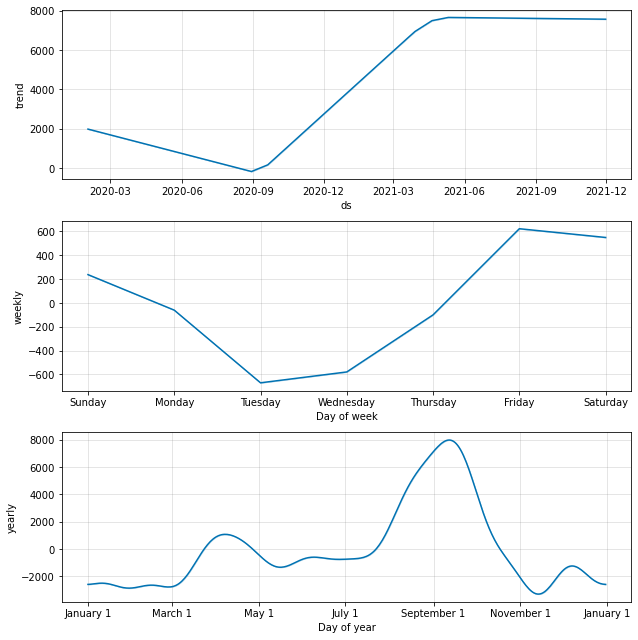

In [75]:
#There are built-in plots in the prophet package that can be used to understand trends.
plot2 = m.plot_components(forecast)

#### Step 7: Run code to test performance of model via cross validation.
It is important that each model is assessed in terms of its performance. Prophet has a built-in diagnostics to do this job. Although diagnostic test will be more meaningful if we have other models we can compare with.

In [80]:
from prophet.diagnostics import cross_validation
#df_cv = cross_validation(m, initial='570 days', period='7 days', horizon = '30 days')

In [77]:
from prophet.diagnostics import performance_metrics
#df_p = performance_metrics(df_cv)
#df_p.head()

# End of Code.